In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pyod.models.knn import KNN
from pyod.utils.utility import standardizer

from impyute.imputation.cs import mice

In [3]:
plt.style.use('seaborn')

In [4]:
df = pd.read_csv('bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.y.unique()

array(['no', 'yes'], dtype=object)

In [6]:
df.shape

(45211, 17)

### Input variables:

#### bank client data:
    1. age (numeric)
    2. job : type of job (categorical:"admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
    3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
    4. education (categorical: "unknown","secondary","primary","tertiary")
    5. default: has credit in default? (binary: "yes","no")
    6. balance: average yearly balance, in euros (numeric) 
    7. housing: has housing loan? (binary: "yes","no")
    8. loan: has personal loan? (binary: "yes","no")
    
#### related to the last contact of the current campaign:
    9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
    10. day: last contact day of the month (numeric)
    11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    12. duration: last contact duration, in seconds (npumeric)
#### other attributes:
    13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
    15. previous: number of contacts performed before this campaign and for this client (numeric)
    16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#### Output variable (desired target):
    17. y - has the client subscribed a term deposit? (binary: "yes","no")

### Checking the type for each column

In [7]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

### Five-point summary of the data:

In [8]:
df.describe(include='all').fillna(0)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,0.000000,12,3,4,2,0.000000,2,2,3,0.000000,12,0.000000,0.000000,0.000000,0.000000,4,2
top,0.000000,blue-collar,married,secondary,no,0.000000,yes,no,cellular,0.000000,may,0.000000,0.000000,0.000000,0.000000,unknown,no
freq,0.000000,9732,27214,23202,44396,0.000000,25130,37967,29285,0.000000,13766,0.000000,0.000000,0.000000,0.000000,36959,39922
mean,40.936210,0,0,0,0,1362.272058,0,0,0,15.806419,0,258.163080,2.763841,40.197828,0.580323,0,0
std,10.618762,0,0,0,0,3044.765829,0,0,0,8.322476,0,257.527812,3.098021,100.128746,2.303441,0,0
min,18.000000,0,0,0,0,-8019.000000,0,0,0,1.000000,0,0.000000,1.000000,-1.000000,0.000000,0,0
25%,33.000000,0,0,0,0,72.000000,0,0,0,8.000000,0,103.000000,1.000000,-1.000000,0.000000,0,0
50%,39.000000,0,0,0,0,448.000000,0,0,0,16.000000,0,180.000000,2.000000,-1.000000,0.000000,0,0
75%,48.000000,0,0,0,0,1428.000000,0,0,0,21.000000,0,319.000000,3.000000,-1.000000,0.000000,0,0


### Unique values in the categorical columns can be observed, along with the frequency of the mode.
### Many of the numeric features, especially balance, duration, pdays, and previous, are skewed, as can be gleaned from the huge difference between the 75% quartile and the maximum values in the respective columns.

In [10]:
df.groupby('y').agg('mean')

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


### The average age of the customers who brought the term deposit is higher than those who did not.
### The average balance of the customers who brought the term deposit is higher than those who did not.

In [11]:
df[df.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


### Thus, there are no duplicates in the dataset

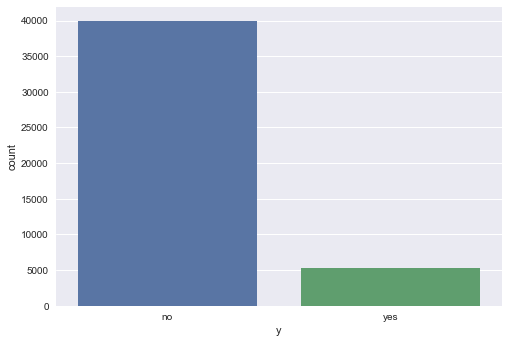

In [12]:
sns.countplot(df['y'])

In [13]:
df['y'].value_counts(normalize=True)*100

no     88.30152
yes    11.69848
Name: y, dtype: float64

### As it can be seen above, the data is highy imbalanced. Only 11% of the entries belong to the 'Yes' category

---

In [14]:
## Getting the categorical and variables from the dataset:
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

In [15]:
print(categorical_columns)
print(numerical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [16]:
# Separating the data into numerical and categorical columns
df_numerical = df[numerical_columns]
df_categorical = df[categorical_columns]

### Checking for normal distribution of numeric columns of the dataset using **Anderson Test** :

In [17]:
from scipy.stats import shapiro
for column in df_numerical.columns:
    test_statistic, p_value = shapiro(df_numerical[column])
    print('p_value for',column,'=',p_value)

p_value for age = 0.0
p_value for balance = 0.0
p_value for day = 0.0
p_value for duration = 0.0
p_value for campaign = 0.0
p_value for pdays = 0.0
p_value for previous = 0.0


### Since the p-value for all the columns is less than 0.05, none of the columns is normally distributed

## Checking the dependency between the categorical columns of the dataset using "Chi2_contingency" test

In [18]:
# Define the function
from scipy.stats import chi2_contingency
    
def chi2_contingency_fun(df,col1,col2):
    table = pd.crosstab(df[col1],df[col2])
    test_statistic, p_value, dof, freq_array = chi2_contingency(table)
    if p_value>0.05:
        print("\n{0} and {1} columns are statistically independent of each other.".format(col1.capitalize(),col2.capitalize()))
        print("We have failed to reject the null hypothesis.")
        print(p_value)
        print()
    else:
        print("{0} and {1} are dependent columns".format(col1.capitalize(),col2.capitalize()))
    return 


In [20]:
# Check for dependency among the categorical columns through a for-loop
col_tuple_list=[]
for col in categorical_columns:
    for col1 in categorical_columns:
        if set([col,col1]) not in col_tuple_list:
            if col!=col1:
                col_tuple_list.append(set([col,col1]))
                chi2_contingency_fun(df,col,col1)

Job and Marital are dependent columns
Job and Education are dependent columns
Job and Default are dependent columns
Job and Housing are dependent columns
Job and Loan are dependent columns
Job and Contact are dependent columns
Job and Month are dependent columns
Job and Poutcome are dependent columns
Job and Y are dependent columns
Marital and Education are dependent columns
Marital and Default are dependent columns
Marital and Housing are dependent columns
Marital and Loan are dependent columns
Marital and Contact are dependent columns
Marital and Month are dependent columns
Marital and Poutcome are dependent columns
Marital and Y are dependent columns
Education and Default are dependent columns
Education and Housing are dependent columns
Education and Loan are dependent columns
Education and Contact are dependent columns
Education and Month are dependent columns
Education and Poutcome are dependent columns
Education and Y are dependent columns

Default and Housing columns are statist

### There is high-level of inter dependency present in the categorical columns of the dataset, which can be removed through one hot encoding, thereby introducing the orthogonal columns.

### In other words, all the categorical features are significant predictors of target varaible.

## Visualize the class distribution of the target column:

In [21]:
# defining a function to get the crosstab of the population that subscribed to the term deposit and a
# categorical column
def crosstab(column):
    return pd.crosstab(df[column],df['y'])

def crosstab_percentage(column):
    return round(pd.crosstab(df[column],df['y'],normalize=0)*100,2)

# defininga a function to show the stacked bar plot for the same
def crosstab_plot(column):
    print("bar plot showing the percentage of 'yes' and 'no' in", column)
    (pd.crosstab(df[column],df['y'],normalize=0)*100).plot.bar(stacked=True,
                                                                                       figsize=(10,5))

## Numerical Columns

In [22]:
df_numerical.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


In [23]:
# attacking the y column to the numerical dataset
df_numerical = pd.concat([df_numerical,df['y']],axis=1)
df_numerical

,age,balance,day,duration,campaign,pdays,previous,y
0,58,2143,5,261,1,-1,0,no
1,44,29,5,151,1,-1,0,no
2,33,2,5,76,1,-1,0,no
3,47,1506,5,92,1,-1,0,no
4,33,1,5,198,1,-1,0,no
...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,yes
45207,71,1729,17,456,2,-1,0,yes
45208,72,5715,17,1127,5,184,3,yes
45209,57,668,17,508,4,-1,0,no


In [24]:
from scipy.stats import mannwhitneyu
data = df_numerical.groupby('y')
data_yes = data.get_group('yes')
data_no = data.get_group('no')
print("Mann-Whitneyu test for numeric columns in the dataset grouped by 'y'-the target variable.")
sig_num_list=[]
for col in data_yes.columns:
    statistic,p_value = tuple(mannwhitneyu(data_yes[col],data_no[col]))
    print("test_statistic and p-value for {0} column: {1}, {2}".format(col,statistic,p_value))
    if p_value <0.05:
        sig_num_list.append(col)
print("\nSince, p-value is less than 0.05, null hypothesis has been rejected. And the columns {0}, as grouped by target variable have different means. Numeric variables {0} are significant predictors of the target.".format(sig_num_list))


Mann-Whitneyu test for numeric columns in the dataset grouped by 'y'-the target variable.
test_statistic and p-value for age column: 103915109.5, 0.031408955093487935
test_statistic and p-value for balance column: 86557474.5, 3.296922904344571e-101
test_statistic and p-value for day column: 99974112.0, 1.6630393167944684e-10
test_statistic and p-value for duration column: 40625701.0, 0.0
test_statistic and p-value for campaign column: 90300543.5, 9.742452436952554e-72
test_statistic and p-value for pdays column: 85889711.5, 1.2420588251888467e-235
test_statistic and p-value for previous column: 83972625.0, 1.745912130207496e-283
test_statistic and p-value for y column: 0.0, 0.0

Since, p-value is less than 0.05, null hypothesis has been rejected. And the columns ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y'], as grouped by target variable have different means. Numeric variables ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y'] are 

In [25]:
df_numerical = df_numerical.drop('y',axis=1)

---

## Working with the 'age' column

In [26]:
df.describe()['age']

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

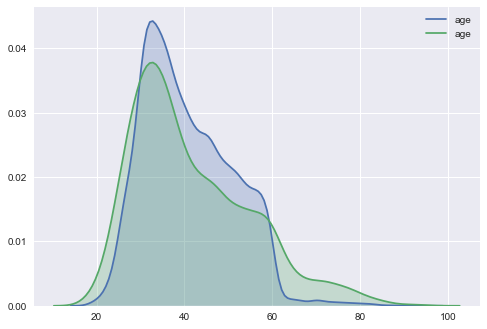

In [28]:
sns.kdeplot(df[df['y']=='no']['age'],shade=True)
sns.kdeplot(df[df['y']=='yes']['age'],shade=True)

In [29]:
print('range:',(df['age'].max() - df['age'].min()))
print('Presence of null values:',df['age'].isnull().any())

range: 77
Presence of null values: False


In [30]:
# creating column containing age brackets
bins = [0,30,40,50,60,100]
bracket = list(map(lambda x,y: str(x)+'<'+str(y),bins,bins[1:]))
bracket

['0<30', '30<40', '40<50', '50<60', '60<100']

In [31]:
df['age_bracket'] = pd.cut(df['age'],bins=[0,30,40,50,60,100],labels=bracket)

In [32]:
(100*pd.crosstab(df['age_bracket'],df['y'],normalize=0))

y,no,yes
age_bracket,,
0<30,83.712660,16.287340
30<40,89.755187,10.244813
40<50,90.933357,9.066643
50<60,89.946696,10.053304
60<100,57.744108,42.255892


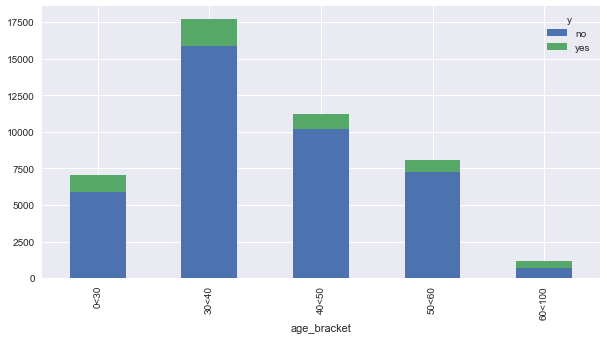

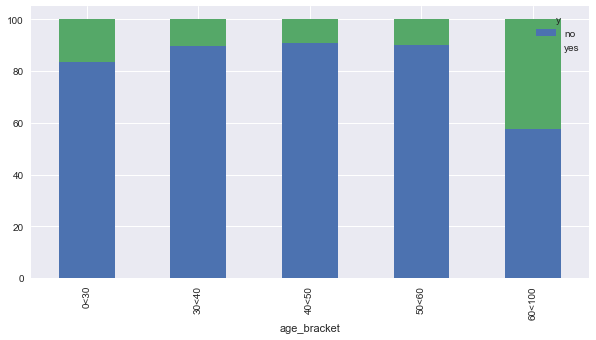

In [33]:
pd.crosstab(df['age_bracket'],df['y']).plot.bar(stacked=True,figsize=(10,5))
# making the percentage plot
(100*pd.crosstab(df['age_bracket'],df['y'],normalize=0)).plot.bar(stacked=True,figsize=(10,5))

### Though the number of people falling in the category '30<40' years is the highest, the proportion of people subscribing to the term deposit is the highest for the category '60-100' years (42%)

In [34]:
# setting the dafault fidgure size
plt.rcParams['figure.figsize'] = (8, 6)

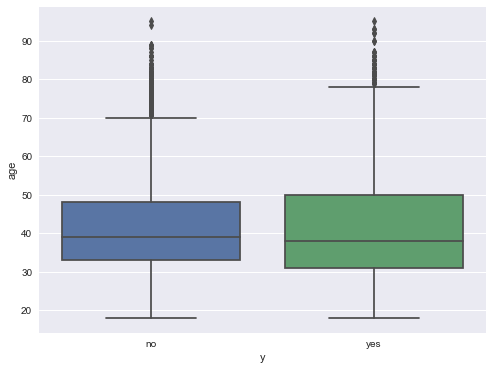

In [35]:
# checking the distribution of age column
sns.boxplot(data=df,y='age',x='y')

## Working with balance column

In [36]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [37]:
print('range:',(df['balance'].max() - df['balance'].min()))
print('Presence of null values:',df['balance'].isnull().any())

range: 110146
Presence of null values: False


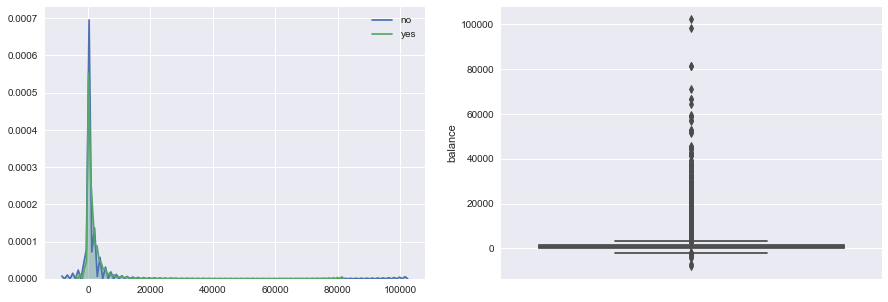

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
sns.kdeplot(df[df['y']=='no']['balance'],shade=True,ax=ax[0],label='no')
sns.kdeplot(df[df['y']=='yes']['balance'],shade=True,ax=ax[0],label='yes')

# checking the distribution of balance column
sns.boxplot(data=df,y='balance',ax=ax[1])

### The data is highly right skewed

In [39]:
def balance_cat(col):
    if col<=0:
        return 'negative'
    if 0<col<=500:
        return 'low'
    if 500<col<=5000:
        return 'medium'
    else:
        return 'high'

In [40]:
df['balance_bracket'] = df['balance'].apply(balance_cat)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_bracket,balance_bracket
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,50<60,medium
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,40<50,low
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,30<40,low
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,40<50,medium
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,30<40,low


In [41]:
(100*pd.crosstab(df['balance_bracket'],df['y'],normalize=0))

y,no,yes
balance_bracket,,
high,84.499121,15.500879
low,89.746720,10.253280
medium,85.744078,14.255922
negative,93.104396,6.895604


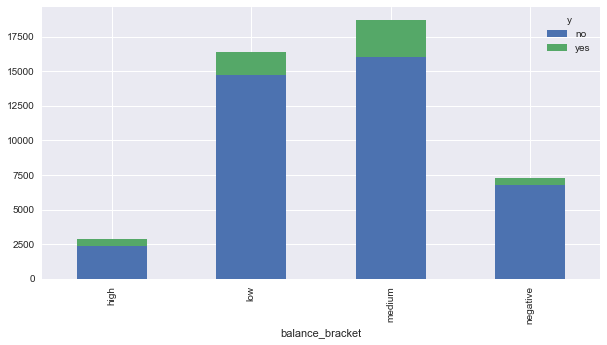

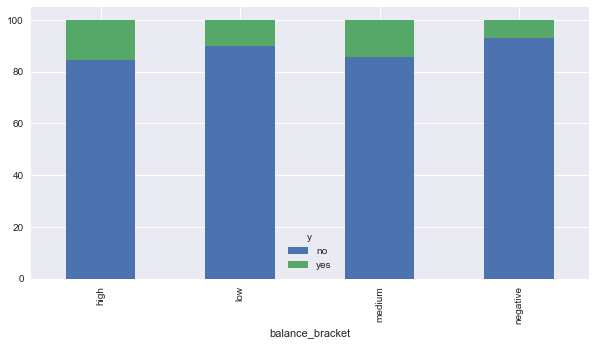

In [42]:
pd.crosstab(df['balance_bracket'],df['y']).plot.bar(stacked=True,figsize=(10,5))
# making the percentage plot
(100*pd.crosstab(df['balance_bracket'],df['y'],normalize=0)).plot.bar(stacked=True,figsize=(10,5))

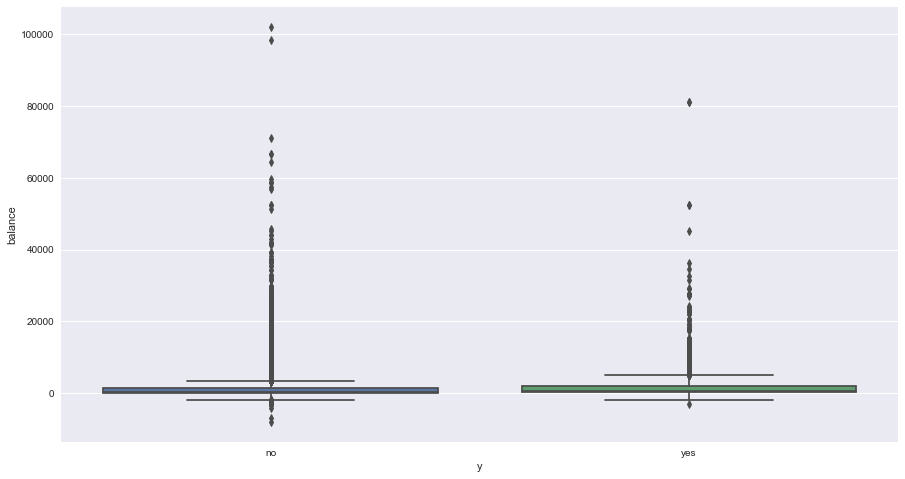

In [45]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df,y='balance',x='y')

## Working with the 'Duration' column

In [46]:
round((df['duration'].describe())/60,2)

count    753.52
mean       4.30
std        4.29
min        0.00
25%        1.72
50%        3.00
75%        5.32
max       81.97
Name: duration, dtype: float64

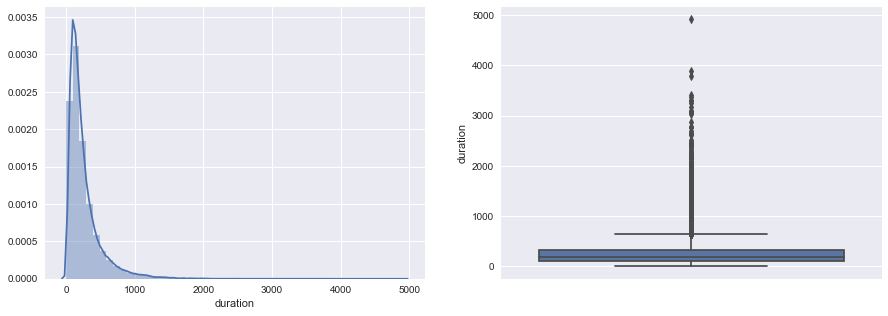

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
sns.distplot(df['duration'],ax=ax[0])
sns.boxplot(x='duration',data=df,ax=ax[1],orient='v')
# plt.tight_layout()

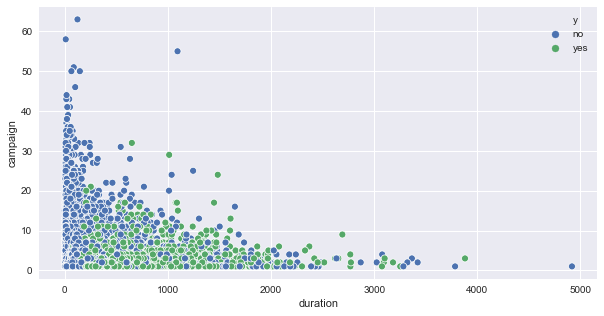

In [49]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='duration',y='campaign',data=df,hue='y')

### It can be observed that most of the subscribed customers have been contacted in the current campaign for less that 5 times. And thus, increasing the number of campaigns may not effectively translate to subscription rate of the targeted customers.

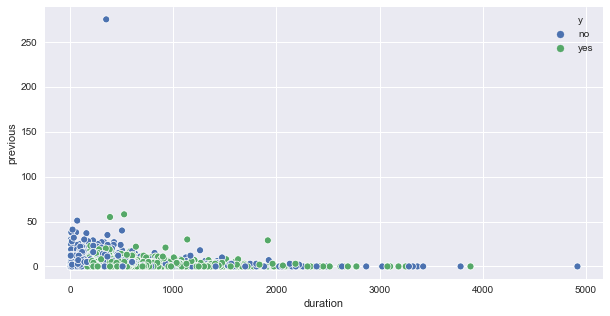

In [51]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='duration',y='previous',data=df,hue='y')

### Subscrition rate for the customers increases with the duration for last contact.Also, contacting a customer above a certain threshold number of times(100), recorded as number of contacts performed before the current campaign, does not yeild a satisfactory result

In [52]:
df[df['previous']>100]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_bracket,balance_bracket
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no,30<40,medium


### One customer has been contacted for 275 times, and yet the subscription is affirmative. While most of the subscribed customers have been, before the current campaign, contacted for less than 50 times.

---

## Day column

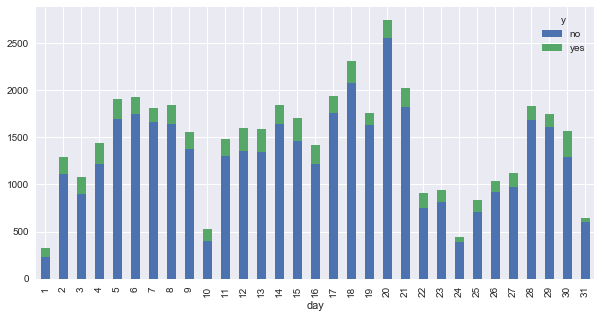

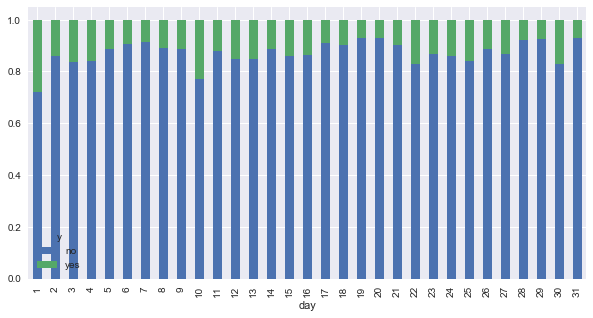

In [53]:
pd.crosstab(df['day'],df['y']).plot.bar(stacked=True,figsize=(10,5))
pd.crosstab(df['day'],df['y'],normalize=0).plot.bar(stacked=True,figsize=(10,5))

### Even though 20th day of month recorded the highest number of calls when the customers were last contacted in the current campaign, highest share of subscriptions to the term deposit is noted on 1st day of the respective month.

## Working with the job column

In [54]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [55]:
crosstab('job')

y,no,yes
job,,
admin.,4540,631
blue-collar,9024,708
entrepreneur,1364,123
housemaid,1131,109
management,8157,1301
retired,1748,516
self-employed,1392,187
services,3785,369
student,669,269


In [56]:
crosstab_percentage('job')

y,no,yes
job,,
admin.,87.80,12.20
blue-collar,92.73,7.27
entrepreneur,91.73,8.27
housemaid,91.21,8.79
management,86.24,13.76
retired,77.21,22.79
self-employed,88.16,11.84
services,91.12,8.88
student,71.32,28.68


bar plot showing the percentage of 'yes' and 'no' in job


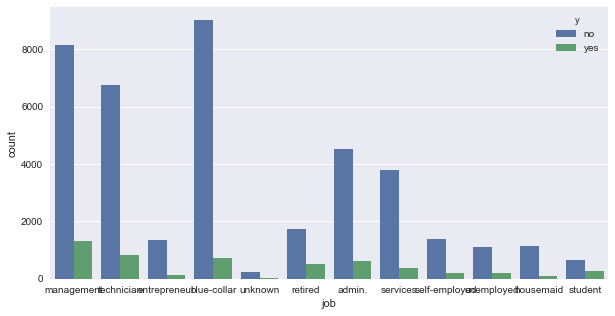

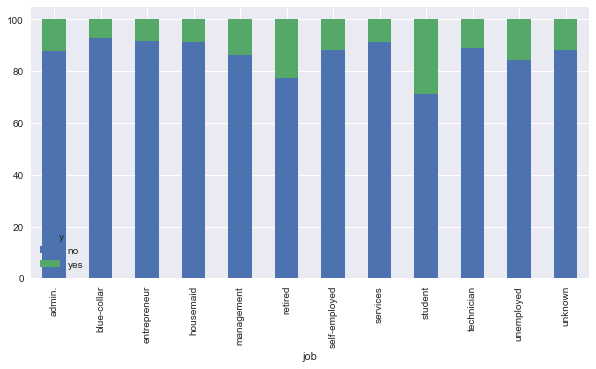

In [58]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',data=df,hue='y')
crosstab_plot('job')

### the crosstab and plot above show that people belonging to categories - student, retired and unemployed are most likely to take the term deposite

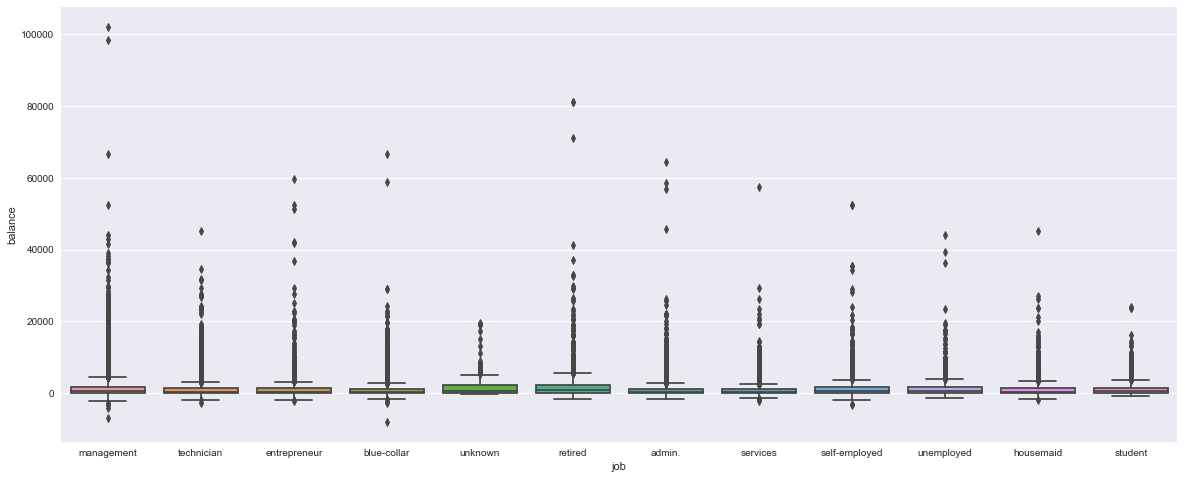

In [59]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df,x='job',y='balance')

## Working with Marital status

In [60]:
married = df['marital'].value_counts()
married

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

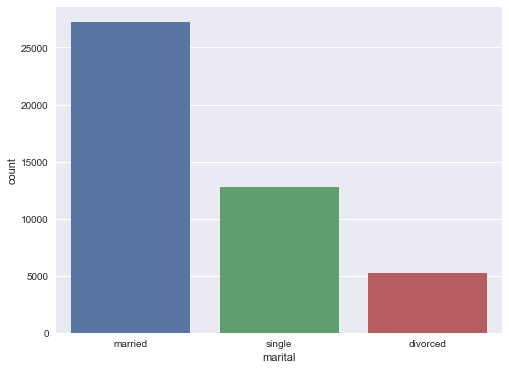

In [61]:
sns.countplot(data=df,x='marital')

In [62]:
crosstab('marital')

y,no,yes
marital,,
divorced,4585,622
married,24459,2755
single,10878,1912


In [63]:
crosstab_percentage('marital')

y,no,yes
marital,,
divorced,88.05,11.95
married,89.88,10.12
single,85.05,14.95


bar plot showing the percentage of 'yes' and 'no' in marital


Text(0, 0.5, 'percentage')

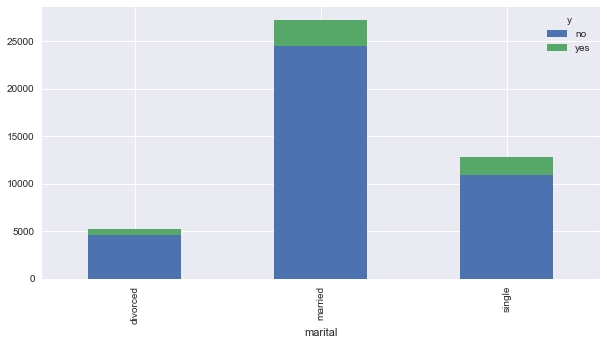

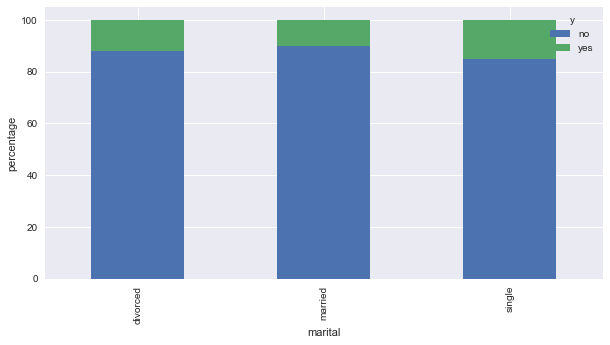

In [64]:
ct = pd.crosstab(df['marital'],df['y'])
ct.plot.bar(stacked=True,figsize=(10,5))
# percentage plot
crosstab_plot('marital')
plt.ylabel('percentage')

### although the population contains married people more but single people are more likely to take term deposits (14.95%)

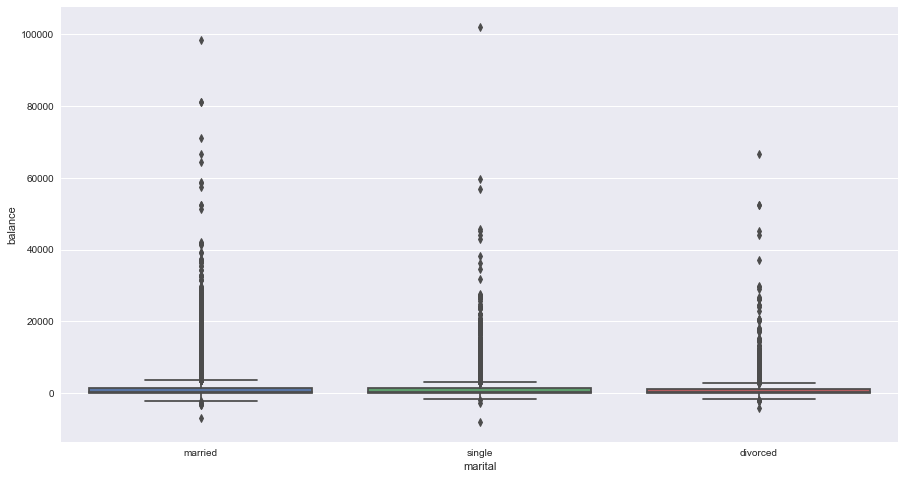

In [65]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df,x='marital',y='balance')

In [66]:
len(df['marital'])

45211

## Working with the Education column

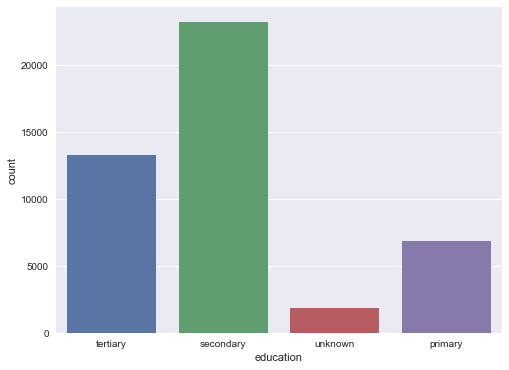

In [67]:
sns.countplot(df['education'])

bar plot showing the percentage of 'yes' and 'no' in education


Text(0, 0.5, 'percentage')

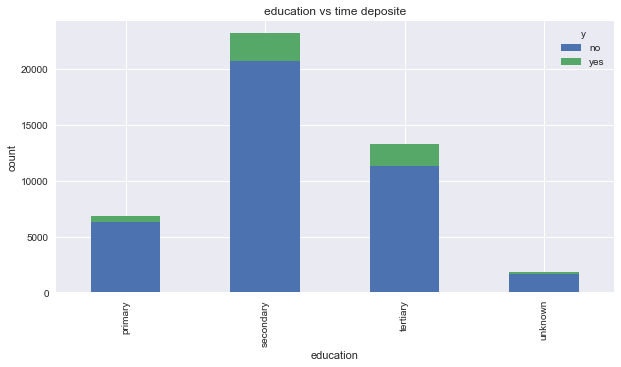

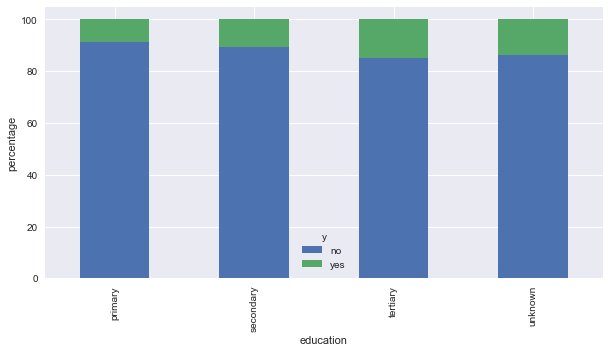

In [68]:
ct = pd.crosstab(df['education'],df['y'])
ct.plot.bar(figsize=(10,5),stacked=True)
plt.ylabel('count')
plt.title('education vs time deposite')
crosstab_plot('education')
plt.ylabel('percentage')

### Customers with secondary level of the education constitute the majority in the whole, those with teritary education seem to be most interested in purchasing the bank loan

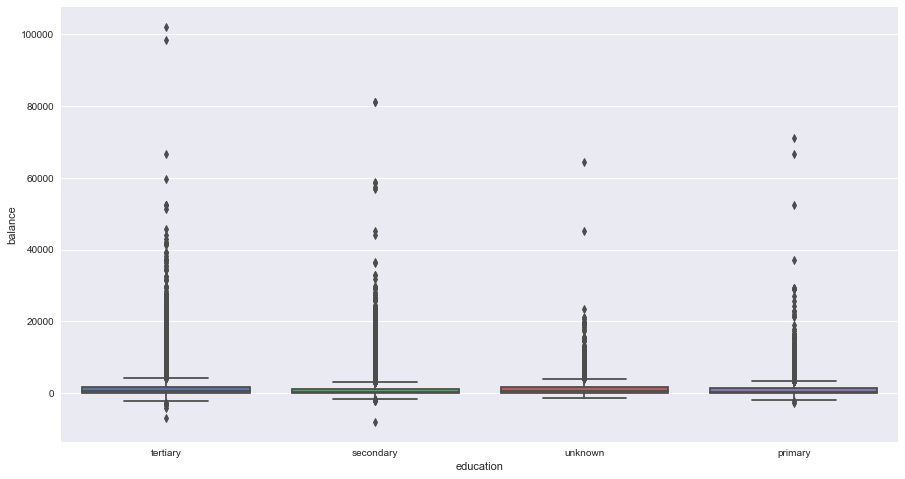

In [69]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df,x='education',y='balance')

## Default, Housing and Loan column

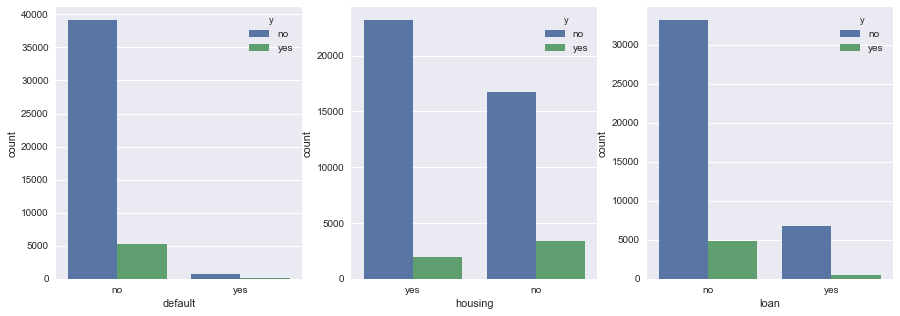

In [70]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()
sns.countplot(df['default'],hue=df['y'],ax=ax[0])
sns.countplot(df['housing'],hue=df['y'],ax=ax[1])
sns.countplot(df['loan'],hue=df['y'],ax=ax[2])

In [71]:
print('default_value_counts:')
print(df['default'].value_counts())

default_value_counts:
no     44396
yes      815
Name: default, dtype: int64


In [72]:
crosstab('default')

y,no,yes
default,,
no,39159,5237
yes,763,52


bar plot showing the percentage of 'yes' and 'no' in default


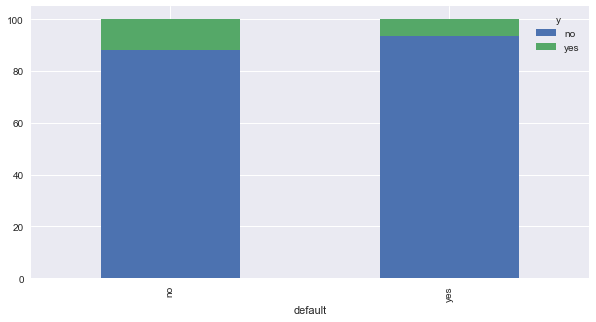

In [73]:
crosstab_plot('default')

In [74]:
print('housing_value_counts:')
print(df['housing'].value_counts())

housing_value_counts:
yes    25130
no     20081
Name: housing, dtype: int64


In [75]:
crosstab('housing')

y,no,yes
housing,,
no,16727,3354
yes,23195,1935


bar plot showing the percentage of 'yes' and 'no' in housing


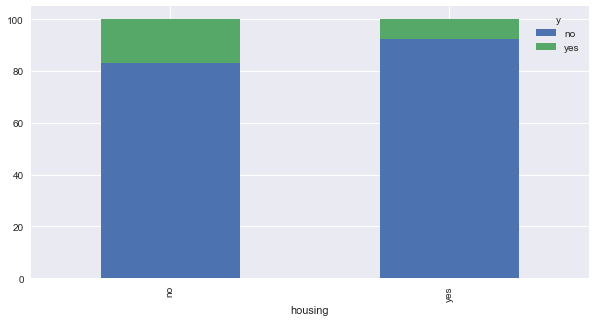

In [76]:
crosstab_plot('housing')

In [77]:
print('loan_value_counts:')
print(df['loan'].value_counts())

loan_value_counts:
no     37967
yes     7244
Name: loan, dtype: int64


In [78]:
crosstab('loan')

y,no,yes
loan,,
no,33162,4805
yes,6760,484


bar plot showing the percentage of 'yes' and 'no' in loan


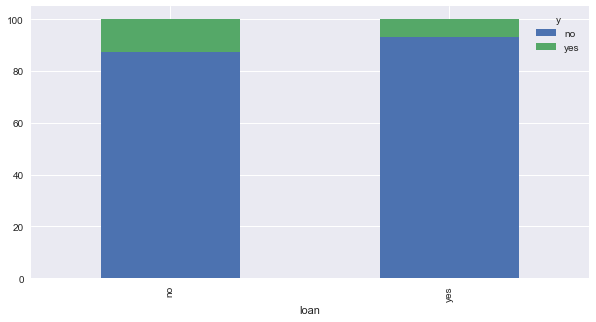

In [79]:
crosstab_plot('loan')

In [80]:
df_categorical = df_categorical.drop('default',axis=1)

### Contact column

In [81]:
df['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [82]:
crosstab('contact')

y,no,yes
contact,,
cellular,24916,4369
telephone,2516,390
unknown,12490,530


In [83]:
crosstab_percentage('contact')

y,no,yes
contact,,
cellular,85.08,14.92
telephone,86.58,13.42
unknown,95.93,4.07


bar plot showing the percentage of 'yes' and 'no' in contact


<Figure size 720x360 with 0 Axes>

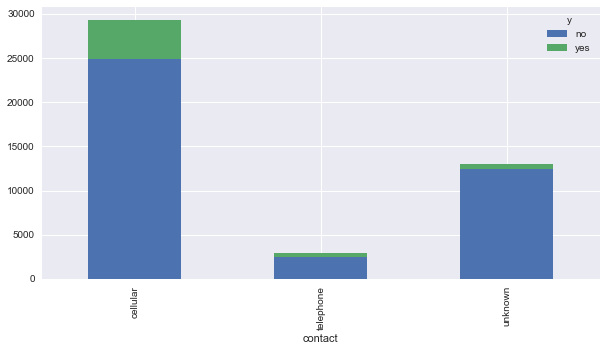

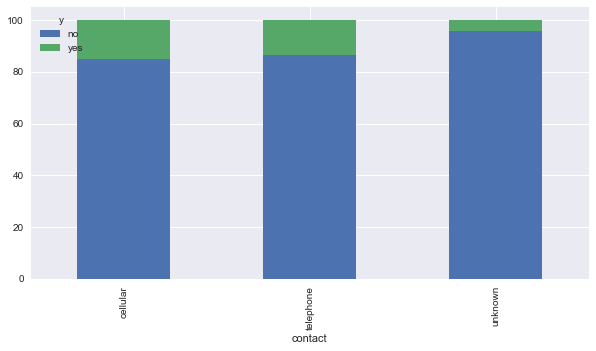

In [84]:
plt.figure(figsize=(10,5))
crosstab('contact').plot.bar(figsize=(10,5),stacked=True)
crosstab_plot('contact')

## Day column

In [85]:
df_numerical['day'].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31])

## Month column

In [86]:
df['month'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

In [87]:
crosstab('month')

y,no,yes
month,,
apr,2355,577
aug,5559,688
dec,114,100
feb,2208,441
jan,1261,142
jul,6268,627
jun,4795,546
mar,229,248
may,12841,925


In [88]:
crosstab_percentage('month')

y,no,yes
month,,
apr,80.32,19.68
aug,88.99,11.01
dec,53.27,46.73
feb,83.35,16.65
jan,89.88,10.12
jul,90.91,9.09
jun,89.78,10.22
mar,48.01,51.99
may,93.28,6.72


bar plot showing the percentage of 'yes' and 'no' in month


Text(0, 0.5, 'percentage')

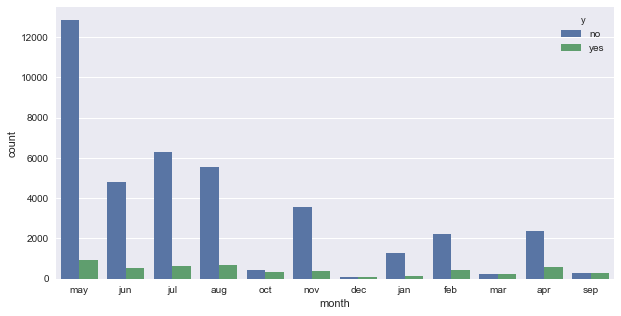

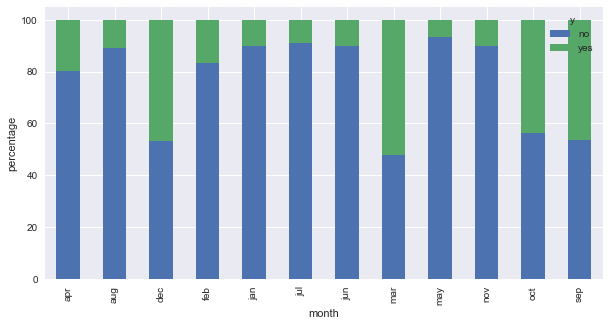

In [89]:
plt.figure(figsize=(10,5))
sns.countplot(df['month'],hue=df['y'])
crosstab_plot('month')
plt.ylabel('percentage')

### Campaign, pday, previous column

In [90]:
df['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

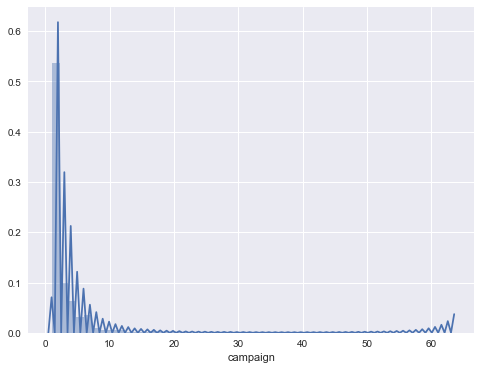

In [91]:
sns.distplot(df['campaign'])

---

### pdays column

In [92]:
df['pdays'].value_counts()

-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 717        1
 589        1
 493        1
 32         1
Name: pdays, Length: 559, dtype: int64

In [93]:
# we convert -1 to 0 as the client has not been contacted yet

In [94]:
df['pdays'] = df['pdays'].apply(lambda x: 0 if x==-1 else x)

### Previous column

In [95]:
df['previous'].value_counts()

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
23         8
20         8
22         6
18         6
24         5
27         5
29         4
25         4
21         4
30         3
28         2
26         2
37         2
38         2
55         1
40         1
35         1
58         1
51         1
41         1
32         1
275        1
Name: previous, dtype: int64

In [96]:
df['previous_cat'] = df['previous'].apply(lambda x: 1 if x !=0 else 0).astype('object')
df['previous_cat'].value_counts(normalize=True)

0    0.817367
1    0.182633
Name: previous_cat, dtype: float64

In [98]:
crosstab('previous_cat')

y,no,yes
previous_cat,,
0,33570,3384
1,6352,1905


In [99]:
crosstab_percentage('previous_cat')

y,no,yes
previous_cat,,
0,90.84,9.16
1,76.93,23.07


### Visualization of whether the customer has been previously contacted or not with target column: 

bar plot showing the percentage of 'yes' and 'no' in previous_cat


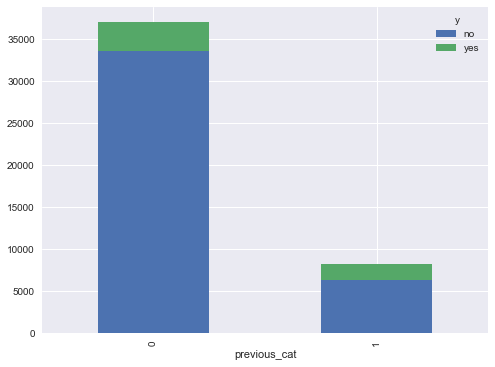

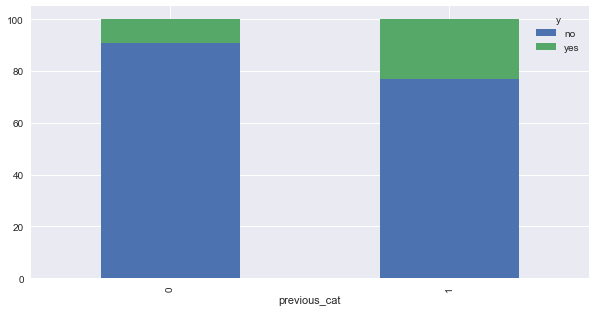

In [102]:
(pd.crosstab(df['previous_cat'],df['y'])).plot.bar(stacked=True)
crosstab_plot('previous_cat')

In [103]:
print("Zeros in the 'previous' column:",
      df['previous'].count()-np.count_nonzero(df['previous']))

print("Zeros in the 'pdays' column:",
      df['pdays'].count()-np.count_nonzero(df['pdays']))

Zeros in the 'previous' column: 36954
Zeros in the 'pdays' column: 36954


### Thus, it can be concluded that, from pdays and previous columns, 36954 customers have not been previously contacted

---

In [104]:
df['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [105]:
df['poutcome'] = df['poutcome'].apply(lambda x:'other' if x=='unknown' else x)
df['poutcome'].value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

### Reducing a redundant level in the categorical feature will keep a check on the number of orthogonal columns that enter into the one-hot encoded dataframe

In [106]:
crosstab('poutcome')

y,no,yes
poutcome,,
failure,4283,618
other,35106,3693
success,533,978


In [107]:
crosstab_percentage('poutcome')

y,no,yes
poutcome,,
failure,87.39,12.61
other,90.48,9.52
success,35.27,64.73


bar plot showing the percentage of 'yes' and 'no' in poutcome


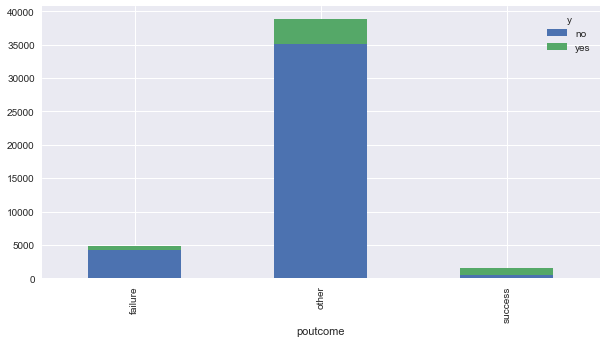

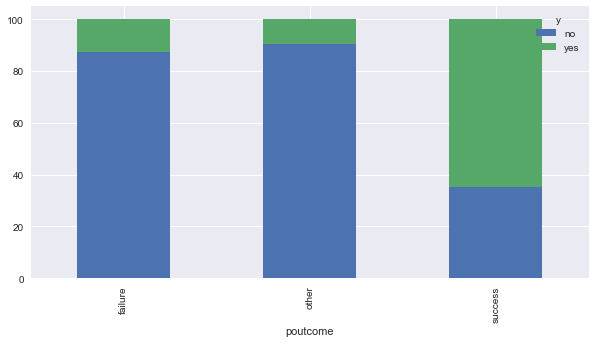

In [108]:
pd.crosstab(df['poutcome'],df['y']).plot.bar(stacked=True,figsize=(10,5))
crosstab_plot('poutcome')

---

In [109]:
# Selecting the categorical columns for one-hot encoding
df1 = df[categorical_columns].drop('y',axis=1)
df1.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
0,management,married,tertiary,no,yes,no,unknown,may,other
1,technician,single,secondary,no,yes,no,unknown,may,other
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,other
3,blue-collar,married,unknown,no,yes,no,unknown,may,other
4,unknown,single,unknown,no,no,no,unknown,may,other


In [110]:
for column in df1.columns:
    x = pd.get_dummies(df1[column],prefix=column)
    df1 = pd.concat([df1,x],axis=1)
    df1 = df1.drop([column],axis=1)

In [111]:
df1.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [112]:
df_categorical = pd.concat([df1,df['y']],axis=1)
df_categorical.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,y
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,no
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,no


### Now the 'df_categorical' dataset contains the orthogonal columns for all the categorical columns along with the target variable

---

### Now we will take the dataset with numercal columns and detect outliers in each columns

### Check for Pearson's correlation of numeric columns

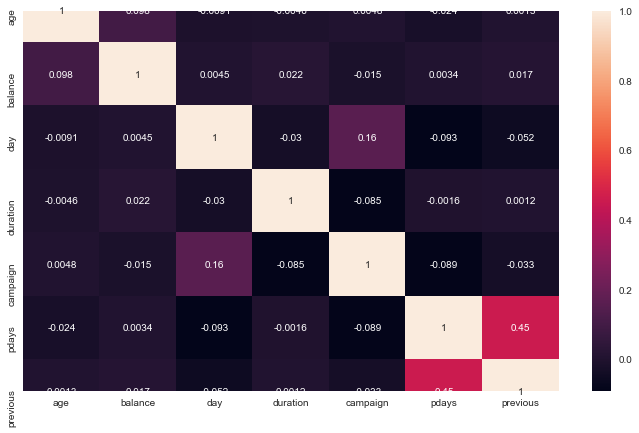

In [114]:
plt.figure(figsize=(12,7))
sns.heatmap(df_numerical.corr(),annot=True)

In [116]:
df_numerical.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


### Function to detect outliers of the columns using Inter Quartile Range method:

In [117]:
len(df_numerical['age'])

45211

In [118]:
def outlier_iqr(column):
    q1,q3 = df_numerical[column].quantile(q=[0.25,0.75])
    uw = q3+1.5*(q3-q1)
    lw = q1-1.5*(q3-q1)
    mask = (df_numerical[column]>uw)|(df_numerical[column]<lw)
    data_outliers = df_numerical[mask][column]
    return (data_outliers)

In [119]:
len(outlier_iqr('age'))

487

### We can see that by using the IQR method, we have significantly decreased the size of our data.
### We shoulg thus use some other method to detect outliers
### Detecting outliers using KNN model from pyod


In [120]:
# Function to get the final outliers
def final_knn_outlier(column,method):
    percent_outliers = (len(outlier_iqr(column))/df_numerical[column].count())
    knn_mean = KNN(contamination = percent_outliers,method = method)
    column_norm = standardizer(df_numerical[[column]])
    label_data = knn_mean.fit(column_norm).labels_
    label_frame_knn_mean = pd.DataFrame(label_data,columns=['outlier_label'])
    outlier_mask = np.where(label_frame_knn_mean['outlier_label']==1,True,False)
    return outlier_mask

### We will replace the outliers with NaN so that we can implement MICE!

In [121]:
# For 'age' columns
age_mask = final_knn_outlier('age','mean')
df_numerical.loc[age_mask,'age'] = np.nan
df_numerical['age'].isnull().sum()

23

### Thus the knn module of pyod has detected 23 outliers in the age columns. Likewise we will do for the rest of the numerical columns

In [122]:
# For balance column
balance_mask = final_knn_outlier('balance','mean')
df_numerical.loc[balance_mask,'balance'] = np.nan
df_numerical['balance'].isnull().sum()

4715

In [123]:
# For duration column
duration_mask = final_knn_outlier('duration','mean')
df_numerical.loc[duration_mask,'duration'] = np.nan
df_numerical['duration'].isnull().sum()

1652

In [124]:
# For campaign column
campaign_mask = final_knn_outlier('campaign','mean')
df_numerical.loc[campaign_mask,'campaign'] = np.nan
df_numerical['campaign'].isnull().sum()

32

In [125]:
# Fro pdays columns
pdays_mask = final_knn_outlier('pdays','mean')
df_numerical.loc[pdays_mask,'pdays'] = np.nan
df_numerical['pdays'].isnull().sum()

460

In [126]:
previous_mask = final_knn_outlier('previous','largest')
df_numerical.loc[previous_mask,'previous'] = np.nan
df_numerical['previous'].isnull().sum()

41

### We have replaced all the outliers with the NaN values, so now we can proceed with MICE imputation

### Outlier-imputation through MICE Package:
### Multivariate imputation by chained equations: accounts for statistical uncertainty in the imputations.


In [128]:
mice_dataset = mice(df_numerical)

In [133]:
mice_dataset.columns = list(df_numerical.columns)
mice_dataset.head()

,age,balance,day,duration,campaign,pdays,previous
0,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0
1,44.0,29.0,5.0,151.0,1.0,-1.0,0.0
2,33.0,2.0,5.0,76.0,1.0,-1.0,0.0
3,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0
4,33.0,1.0,5.0,198.0,1.0,-1.0,0.0


In [134]:
mice_dataset.isnull().sum()

age         0
balance     0
day         0
duration    0
campaign    0
pdays       0
previous    0
dtype: int64

### As it can be seen above, we have imputed all the missing values using MICE

## Now making a new dataframe using the one-hot encoded dataframe and the mice-imputed dataset

In [137]:
df = pd.concat([mice_dataset,df_categorical],axis=1)

In [138]:
df.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,y
0,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
1,44.0,29.0,5.0,151.0,1.0,-1.0,0.0,0,0,0,...,0,0,1,0,0,0,0,1,0,no
2,33.0,2.0,5.0,76.0,1.0,-1.0,0.0,0,0,1,...,0,0,1,0,0,0,0,1,0,no
3,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0,0,1,0,...,0,0,1,0,0,0,0,1,0,no
4,33.0,1.0,5.0,198.0,1.0,-1.0,0.0,0,0,0,...,0,0,1,0,0,0,0,1,0,no


In [140]:
df.shape

(45211, 51)

In [153]:
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else 1)
df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

---

## Model Building

In [173]:
x = df.drop('y',axis=1)
y = df['y']

In [174]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x = ss.fit_transform(x)

In [175]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)

### Model 1 = K nearest neighbor

In [176]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors':list(range(3,11))
}
from sklearn.model_selection import GridSearchCV
grid_knn = GridSearchCV(estimator=knn, param_grid=knn_params)
best_knn = grid_knn.fit(x_train,y_train)
best_params = best_knn.best_params_
print(best_params)

{'n_neighbors': 10}


In [177]:
knn = KNeighborsClassifier(n_neighbors=10)
model1 = knn.fit(x_train,y_train)
predict_knn = model1.predict(x_test)

In [178]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_knn
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  12142
wrong predictions:  1422


In [179]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [180]:
ar_knn = accuracy_score(y_test, predict_knn)*100
print('accuracy score =',round(ar_knn,2))

accuracy score = 89.52


In [181]:
mr_knn = 100 - ar_knn
print('misclassigication rate of KNN = ',round(mr_knn,2),'%')

misclassigication rate of KNN =  10.48 %


In [182]:
cm_knn = confusion_matrix(y_test, predict_knn)
print(cm_knn)

[[11800   213]
 [ 1209   342]]


In [183]:
f1_knn = f1_score(y_test,predict_knn)
f1_knn

0.3247863247863248

In [184]:
# model complexity
neigh = np.arange(3,11)
train_accuracy = []
test_accuracy = []
# loop over different values of k
for i, k in enumerate(neigh):
    # k from 3 to 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

# plotting
plt.figure(figsize=[13,8])
plt.plot(neigh, test_accuracy, label='Testing Accuracy')
plt.plot(neigh, train_accuracy, label='Training Accuracy')
plt.legend()
plt.title('Value vs Accuracy',fontsize=12)
plt.xlabel('Number of Neighbors',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xticks(neigh)
plt.grid()
plt.show()

print('Best accuracy is {} with k = {}'. format(np.max(test_accuracy), 
                                                test_accuracy.index(np.max(test_accuracy))+3))

KeyboardInterrupt: 

In [185]:
from sklearn.metrics import classification_report
cr_knn = classification_report(y_test,predict_knn)
print('classification report of logistic regression','\n',cr_knn)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     12013
           1       0.62      0.22      0.32      1551

    accuracy                           0.90     13564
   macro avg       0.76      0.60      0.63     13564
weighted avg       0.87      0.90      0.87     13564



### Model 2 = Logistic Regression

In [222]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
model2 = lr.fit(x_train,y_train)
predict_lr = model2.predict(x_test)

In [223]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_lr
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  12180
wrong predictions:  1384


In [224]:
ar_lr = accuracy_score(y_test, predict_lr)*100
print('accuracy score =',round(ar_lr,2))

accuracy score = 89.8


In [225]:
mr_lr = 100 - ar_lr
print('misclassigication rate of Logistic regression = ',round(mr_lr,2),'%')

misclassigication rate of Logistic regression =  10.2 %


In [226]:
cm_lr = confusion_matrix(y_test, predict_lr)
print(cm_lr)

[[11750   263]
 [ 1121   430]]


In [227]:
f1_lr = f1_score(y_test,predict_lr)
f1_lr

0.38324420677361853

In [228]:
cr_lr = classification_report(y_test,predict_lr)
print('classification report of logistic regression','\n',cr_lr)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     12013
           1       0.62      0.28      0.38      1551

    accuracy                           0.90     13564
   macro avg       0.77      0.63      0.66     13564
weighted avg       0.88      0.90      0.88     13564



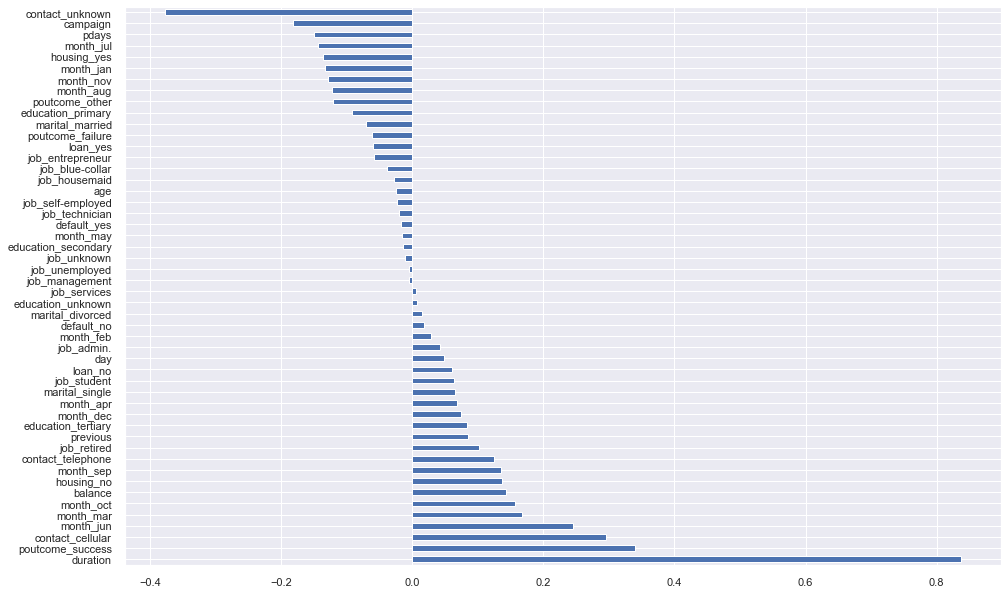

In [229]:
feature_importance_logistic = pd.Series(np.std(x_train,0)*model2.coef_.ravel(),index = df.drop('y',axis=1).columns)
sns.set(rc={'figure.figsize':(15.7,10.27)})
feature_importance_logistic.sort_values(ascending=False).plot(kind='barh')

### ROC Curve

In [206]:
from sklearn.metrics import roc_curve

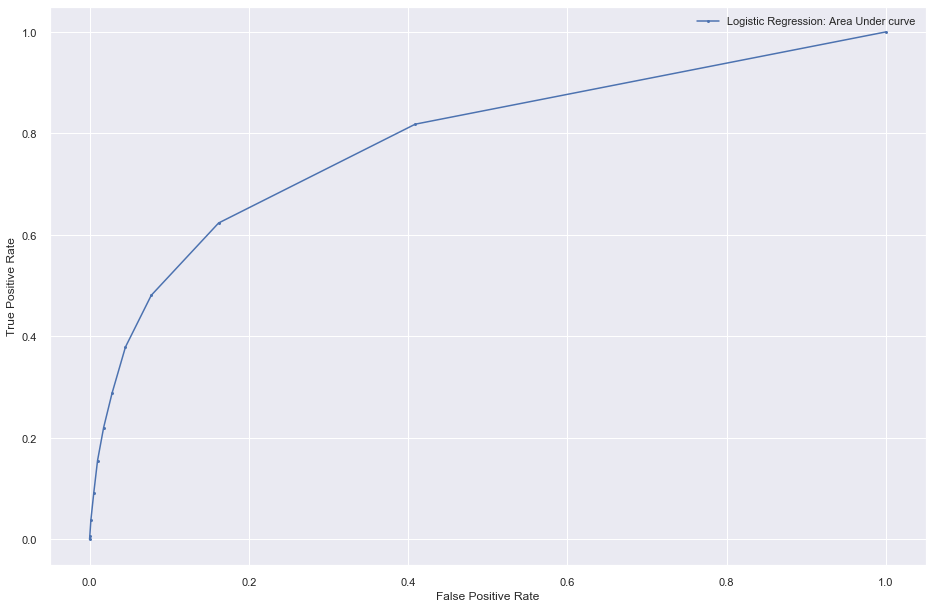

In [210]:
positive_prob = model1.predict_proba(x_test)[:,1]
logistic_fpr,logistic_tpr,logistic_thresholds = roc_curve(y_test,positive_prob)
plt.plot(logistic_fpr,logistic_tpr,marker='.',label='Logistic Regression: Area Under curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Over Sampling using SMOTE
### By oversampling only on the training data, none of the information in validation data is being used to create synthetic observation and results should be generalizable.


In [213]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1)
x_train_smote, y_train_smote = smote.fit_sample(x_train,y_train.values.ravel())

In [214]:
lr = LogisticRegression(max_iter=1000)
model3 = lr.fit(x_train_smote,y_train_smote)
predict_lr_smote = model3.predict(x_test)

In [215]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_lr_smote
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  10797
wrong predictions:  2767


In [217]:
acc_lr_smote = accuracy_score(y_test, predict_lr_smote)*100
print('accuracy score =',round(acc_lr_smote,2))

accuracy score = 79.6


In [220]:
mr_lr_smote = 100 - acc_lr_smote
print('misclassigication rate of Logistic regression = ',round(mr_lr_smote,2),'%')

misclassigication rate of Logistic regression =  20.4 %


In [221]:
f1_lr_smote = f1_score(y_test,predict_lr_smote)
f1_lr_smote

0.4513186595280587

In [219]:
print(classification_report(y_test,predict_lr_smote))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     12013
           1       0.33      0.73      0.45      1551

    accuracy                           0.80     13564
   macro avg       0.64      0.77      0.66     13564
weighted avg       0.89      0.80      0.83     13564



### Over-sampling has improved f1-score at the same time reducing the acuracy score from 89% to 79.6 % because the samples created using SMOTE are synthetic and not realistic

## Under Sampling using Near miss

In [231]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
x_undersampled,y_undersampled = nm.fit_sample(x_train,y_train.values.ravel())

In [233]:
model4 = lr.fit(x_undersampled,y_undersampled)
predict_lr_nearmiss = model4.predict(x_test)

In [234]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_lr_nearmiss
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  6651
wrong predictions:  6913


In [235]:
acc_lr_nearmiss = accuracy_score(y_test, predict_lr_nearmiss)*100
print('accuracy score =',round(acc_lr_nearmiss,2))

accuracy score = 49.03


In [236]:
mr_lr_nearmiss = 100 - acc_lr_nearmiss
print('misclassigication rate of Logistic regression = ',round(mr_lr_nearmiss,2),'%')

misclassigication rate of Logistic regression =  50.97 %


In [237]:
f1_lr_nearmiss = f1_score(y_test,predict_lr_nearmiss)
f1_lr_nearmiss

0.2752909109969598

In [238]:
print(classification_report(y_test,predict_lr_nearmiss))

              precision    recall  f1-score   support

           0       0.96      0.44      0.61     12013
           1       0.16      0.85      0.28      1551

    accuracy                           0.49     13564
   macro avg       0.56      0.65      0.44     13564
weighted avg       0.87      0.49      0.57     13564



### Nearmiss improved recall score from 73% to 85%, at the cost of accuracy.
### F1 is a more realistic evaluation metric for imbalanced classification models because it takes into account both precision and recall.

---

### Model 5 using  Naive Bayes

In [239]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

In [240]:
nb = GaussianNB()
model5 = nb.fit(x_train,y_train)
predict_nb = model5.predict(x_test)

In [241]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_nb
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  11536
wrong predictions:  2028


In [242]:
ar_nb = accuracy_score(y_test, predict_nb)*100
print('accuracy score =',round(ar_nb,2),'%')

accuracy score = 85.05 %


In [243]:
mr_nb = 100 - ar_nb
print('misclassigication rate of Naive Bayes = ',round(mr_nb,2),'%')

misclassigication rate of Naive Bayes =  14.95 %


In [244]:
cr_nb = classification_report(y_test,predict_nb)
print('classification report of logistic regression','\n',cr_nb)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.93      0.90      0.91     12013
           1       0.38      0.47      0.42      1551

    accuracy                           0.85     13564
   macro avg       0.65      0.69      0.67     13564
weighted avg       0.87      0.85      0.86     13564



### Model 6: Naive Bayes using over-sampling dataset

In [245]:
model6 = nb.fit(x_train_smote,y_train_smote)
predict_nb_smote = model6.predict(x_test)

In [246]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_nb_smote
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  11184
wrong predictions:  2380


In [247]:
ar_nb_smote = accuracy_score(y_test, predict_nb_smote)*100
print('accuracy score =',round(ar_nb_smote,2),'%')

accuracy score = 82.45 %


In [248]:
mr_nb_smote = 100 - ar_nb_smote
print('misclassigication rate of Naive Bayes = ',round(mr_nb_smote,2),'%')

misclassigication rate of Naive Bayes =  17.55 %


In [249]:
cr_nb_smote = classification_report(y_test,predict_nb_smote)
print('classification report of logistic regression','\n',cr_nb_smote)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     12013
           1       0.34      0.56      0.42      1551

    accuracy                           0.82     13564
   macro avg       0.64      0.71      0.66     13564
weighted avg       0.87      0.82      0.84     13564



### Using over-sampled dataset for Naive Bayes decreases the accuracy from 85% to 82% but the f1-score remains the same when compared with the orifinal dataset model
### But it enhances the recall of the minority class from 47% to 56%

---

### Model 7 = Decision Tree

In [250]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [252]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[3,4,5,6],
    'max_features':['auto','log2','sqrt'],
    'random_state':[1]
}
# checking best parameters for Decision Tree
grid_tree = GridSearchCV(estimator=dt, param_grid=parameters)
train_tree = grid_tree.fit(x_train,y_train)
best_params = train_tree.best_params_
best_params

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'random_state': 1,
 'splitter': 'best'}

In [253]:
# Now training the tree with the above mentiones parameters
dt = DecisionTreeClassifier(criterion='gini',max_depth=6, max_features='auto',random_state=1,
                            splitter='random')
model7 = dt.fit(x_train,y_train)
predict_dt = model7.predict(x_test)

In [254]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_dt
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  12151
wrong predictions:  1413


In [255]:
ar_dt = accuracy_score(y_test, predict_dt)*100
print('accuracy score =',round(ar_dt,2),'%')

accuracy score = 89.58 %


In [256]:
mr_dt = 100 - ar_dt
print('misclassification rate of Decision Tree = ',round(mr_dt,2),'%')

misclassification rate of Decision Tree =  10.42 %


In [257]:
cr_dt = classification_report(y_test,predict_dt)
print('classification report of logistic regression','\n',cr_dt)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     12013
           1       0.66      0.18      0.29      1551

    accuracy                           0.90     13564
   macro avg       0.78      0.59      0.62     13564
weighted avg       0.88      0.90      0.87     13564



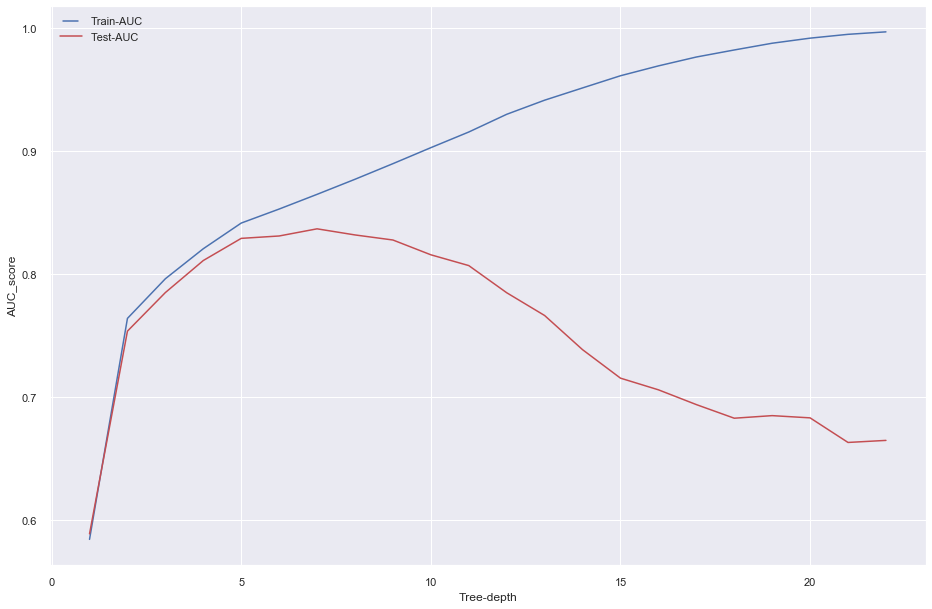

In [267]:
from sklearn.metrics import auc
max_depths = np.linspace(1,22,22,endpoint=True) 
train_result = []
test_result = []
for max_depth in max_depths:
    tree_model = DecisionTreeClassifier(max_depth = max_depth)
    tree_model.fit(x_train,y_train)
    tree_pred = tree_model.predict_proba(x_train)[:,1]
    fpr,tpr,thresholds = roc_curve(y_train,tree_pred)
    roc_auc = auc(fpr,tpr)
    train_result.append(roc_auc)
    tree_test_pred = tree_model.predict_proba(x_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_test,tree_test_pred)
    roc_auc = auc(fpr,tpr)
    test_result.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1,=plt.plot(max_depths,train_result,'b',label="Train-AUC")
line2,=plt.plot(max_depths,test_result,'r',label="Test-AUC")
plt.legend(handler_map={line1:HandlerLine2D(numpoints=2)})
plt.ylabel("AUC_score")
plt.xlabel("Tree-depth")
plt.show()

### Inference: The model overfits for large depth values

### Model 8: Decision Tree using over-sampling dataset

In [258]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[3,4,5,6],
    'max_features':['auto','log2','sqrt'],
    'random_state':[1]
}
# checking best parameters for Decision Tree
grid_tree = GridSearchCV(estimator=dt, param_grid=parameters)
train_tree = grid_tree.fit(x_train_smote,y_train_smote)
best_params = train_tree.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'log2',
 'random_state': 1,
 'splitter': 'best'}

In [260]:
# Now training the tree with the above mentiones parameters
dt = DecisionTreeClassifier(criterion='entropy',max_depth=6, max_features='log2',random_state=1,
                            splitter='best')
model8 = dt.fit(x_train_smote,y_train_smote)
predict_dt_smote = model8.predict(x_test)

In [261]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_dt_smote
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  9534
wrong predictions:  4030


In [262]:
ar_dt_smote = accuracy_score(y_test, predict_dt_smote)*100
print('accuracy score =',round(ar_dt_smote,2),'%')

accuracy score = 70.29 %


In [263]:
mr_dt_smote = 100 - ar_dt_smote
print('misclassification rate of Decision Tree = ',round(mr_dt_smote,2),'%')

misclassification rate of Decision Tree =  29.71 %


In [264]:
cr_dt_smote = classification_report(y_test,predict_dt_smote)
print('classification report of logistic regression','\n',cr_dt_smote)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.95      0.70      0.81     12013
           1       0.24      0.74      0.36      1551

    accuracy                           0.70     13564
   macro avg       0.60      0.72      0.58     13564
weighted avg       0.87      0.70      0.76     13564



### Using over-sampled dataset for Decision Tree decreases the accuracy from 90% to 70% but increases the f1-score from 29% to 36% and recall for the the minority class from 18% to 74%

---

### Model 9: Random Forest

In [268]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
model9 = rf.fit(x_train,y_train)
predict_rf = model9.predict(x_test)

In [269]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == predict_rf
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  12188
wrong predictions:  1376


In [270]:
ar_rf = accuracy_score(y_test, predict_rf)*100
print('accuracy score =',round(ar_rf,2),'%')

accuracy score = 89.86 %


In [271]:
mr_rf = 100 - ar_rf
print('misclassification rate of Decision Tree = ',round(mr_rf,2),'%')

misclassification rate of Decision Tree =  10.14 %


In [272]:
cr_rf = classification_report(y_test,predict_rf)
print('classification report of logistic regression','\n',cr_rf)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     12013
           1       0.62      0.29      0.39      1551

    accuracy                           0.90     13564
   macro avg       0.77      0.63      0.67     13564
weighted avg       0.88      0.90      0.88     13564



### The final testing ROC AUC for the Random Forest was 0.9 compared to 0.67 for the single decision tree.

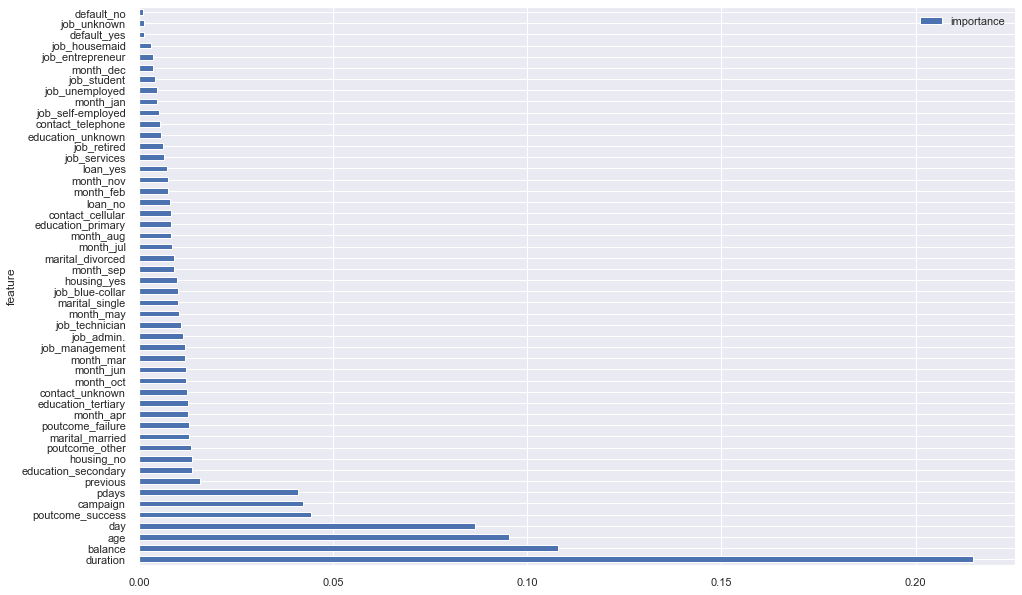

In [284]:
data = list(zip(df.columns.to_list(),model9.feature_importances_))
rf_feature_importance = pd.DataFrame(data,columns='feature importance'.split())
rf_feature_importance = rf_feature_importance.set_index('feature').sort_values(ascending=False,by='importance')
rf_feature_importance.plot(kind='barh')

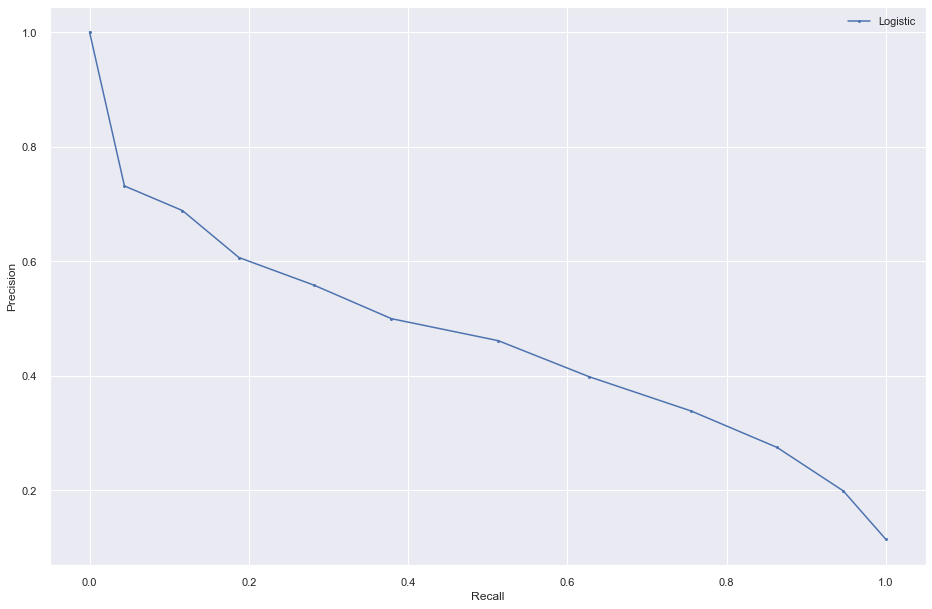

In [294]:
test_scores_random = model9.predict_proba(x_test)

# plotting the precision recall curve
from sklearn.metrics import precision_recall_curve
random_precision,random_recall,random_thresholds = precision_recall_curve(y_test,test_scores_random[:,1])
plt.plot(random_recall,random_precision,marker='.',label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Bagging using Logistic Regression 

In [296]:
from sklearn.ensemble import BaggingClassifier
bag_model = BaggingClassifier(base_estimator=lr,n_estimators=100)
model10 = bag_model.fit(x_train,y_train.values.ravel())
y_pred_bagging = model10.predict(x_test)

In [306]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == y_pred_bagging
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  12180
wrong predictions:  1384


In [307]:
ar_bagging = accuracy_score(y_test, y_pred_bagging)*100
print('accuracy score =',round(ar_bagging,2),'%')

accuracy score = 89.8 %


In [308]:
mr_bagging = 100 - ar_bagging
print('misclassification rate = ',round(mr_bagging,2),'%')

misclassification rate =  10.2 %


In [309]:
cr_bagging = classification_report(y_test,y_pred_bagging)
print('classification report of bagging model','\n',cr_bagging)

classification report of logistic regression 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     12013
           1       0.62      0.28      0.38      1551

    accuracy                           0.90     13564
   macro avg       0.77      0.63      0.66     13564
weighted avg       0.88      0.90      0.88     13564



### Bagging using Logistic Regression with oversampled data

In [303]:
model11 = bag_model.fit(x_train_smote,y_train_smote)
y_pred_bagging_smote = model11.predict(x_test)

In [310]:
# checking correct predictions
y_true = np.array(y_test.values)
check = y_true == y_pred_bagging_smote
correct = np.count_nonzero(check)
wrong = x_test.shape[0] - correct
print('correct predictions: ',correct)
print('wrong predictions: ',wrong)

correct predictions:  10800
wrong predictions:  2764


In [311]:
ar_bagging_smote = accuracy_score(y_test, y_pred_bagging_smote)*100
print('accuracy score =',round(ar_bagging_smote,2),'%')

accuracy score = 79.62 %


In [312]:
mr_bagging_smote = 100 - ar_bagging_smote
print('misclassification rate = ',round(mr_bagging_smote,2),'%')

misclassification rate =  20.38 %


In [314]:
cr_bagging_smote = classification_report(y_test,y_pred_bagging_smote)
print('classification report of bagging model over-sampling','\n',cr_bagging_smote)

classification report 
               precision    recall  f1-score   support

           0       0.96      0.80      0.87     12013
           1       0.33      0.73      0.45      1551

    accuracy                           0.80     13564
   macro avg       0.64      0.77      0.66     13564
weighted avg       0.89      0.80      0.83     13564



---

### Boosting with Decision Tree

In [316]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='gini',max_depth=6, max_features='auto',random_state=1,
                            splitter='random')
boosting_classifier = AdaBoostClassifier(tree,n_estimators=100,random_state=1)
model12 = boosting_classifier.fit(x_train,y_train)
y_pred_dt_boosting = model12.predict(x_test)

In [326]:
model13 = boosting_classifier.fit(x_train_smote,y_train_smote)
y_pred_dt_boosting_smote = model13.predict(x_test)

In [327]:
print("Accuracy score for boosting classifier (decision tree):",accuracy_score(y_test,y_pred_dt_boosting))
print("F1 score for boosting classifier (decision tree):",f1_score(y_test,y_pred_dt_boosting))
print("Accuracy score for boosting classifier (decision tree), with over-sampling:",accuracy_score(y_test,y_pred_dt_boosting_smote))
print("F1 score for boosting classifier (decision tree), with over-sampling:",f1_score(y_test,y_pred_dt_boosting_smote))


Accuracy score for boosting classifier (decision tree): 0.8852108522559717
F1 score for boosting classifier (decision tree): 0.42609657206044965
Accuracy score for boosting classifier (decision tree), with over-sampling: 0.8563845473311708
F1 score for boosting classifier (decision tree), with over-sampling: 0.4415137614678899


In [320]:
cr_dt_boosting = classification_report(y_test,y_pred_dt_boosting)
print('classification report of boosting model of decision tree','\n',cr_dt_boosting)

classification report of boosting model of decision tree 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     12013
           1       0.50      0.37      0.43      1551

    accuracy                           0.89     13564
   macro avg       0.71      0.66      0.68     13564
weighted avg       0.87      0.89      0.88     13564



In [325]:
cr_dt_boosting_smote = classification_report(y_test,y_pred_dt_boosting_smote)
print('classification report of boosting model of decision tree using over-sampling','\n',cr_dt_boosting_smote)

classification report of boosting model of decision tree using over-sampling 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92     12013
           1       0.40      0.50      0.44      1551

    accuracy                           0.86     13564
   macro avg       0.67      0.70      0.68     13564
weighted avg       0.87      0.86      0.86     13564



### So the accuracy fall down from 89% to 86% but the f1-score fro minority class has increased from 37% to 50%

### Boosing using Logistic Regression

In [329]:
boosting_classifier = AdaBoostClassifier(lr,n_estimators=100,random_state=1)

model14 = boosting_classifier.fit(x_train,y_train)
y_pred_lr_boosting = model14.predict(x_test)

In [330]:
model15 = boosting_classifier.fit(x_train_smote,y_train_smote)
y_pred_lr_boosting_smote = model15.predict(x_test)

In [331]:
print("Accuracy score for boosting classifier (logistic regression):",accuracy_score(y_test,y_pred_lr_boosting))
print("F1 score for boosting classifier (logistic regression):",f1_score(y_test,y_pred_lr_boosting))
print("Accuracy score for boosting classifier (logistic regression), with over-sampling:",accuracy_score(y_test,y_pred_lr_boosting_smote))
print("F1 score for boosting classifier (logistic regression), with over-sampling:",f1_score(y_test,y_pred_lr_boosting_smote))


Accuracy score for boosting classifier (logistic regression): 0.8960483633146564
F1 score for boosting classifier (logistic regression): 0.3733333333333334
Accuracy score for boosting classifier (logistic regression), with over-sampling: 0.8048510763786494
F1 score for boosting classifier (logistic regression), with over-sampling: 0.4590230942162273
